In [1]:
import torch
import random
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt 
from torchvision.utils import make_grid
from discriminator import Discriminator
from generator import Generator
import torchvision.transforms as transforms
import torch.nn.functional as F 
import torch.utils.data
import torchvision
import numpy as np
from torch.autograd import Variable

In [2]:
#HyperParameters
Batch_size=100
lr=0.0005
epochs=10

In [3]:
Data_transform=transforms.Compose([ transforms.Resize(64),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=(0.5,),std=(0.5,))])

In [4]:
trainset=torchvision.datasets.MNIST(root='../data',train=True,download=True,transform=Data_transform)
trainloader=DataLoader(trainset,batch_size=Batch_size,num_workers=2,shuffle=True)

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [6]:
def showimage(images):
    image=images.cpu().numpy()
    image=image*0.5+0.5
    plt.imshow(np.transpose(images, axes=(1, 2, 0)))
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([100, 1, 64, 64])


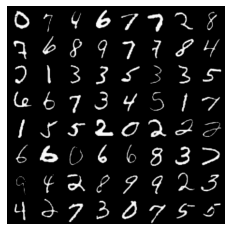

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size())
showimage(make_grid(images[0:64]))

In [8]:
generator=Generator()
generator.apply(weights_init)
discriminator=Discriminator()
discriminator.apply(weights_init)

gen_params=list(generator.parameters())
print(len(gen_params))

disc_params=list(discriminator.parameters())
print(len(disc_params))


14
12


In [9]:
#LOSS
adversarial_loss=nn.BCELoss()
auxiliary_loss=nn.CrossEntropyLoss()

optimG = optim.Adam(generator.parameters(), lr, betas=(0.5, 0.999))
optimD = optim.Adam(discriminator.parameters(), lr, betas=(0.5, 0.999))

In [10]:
def train_generator(batch_size,generator,discriminator):
    optimG.zero_grad()
    z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, 100))))
    gen_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size)))
    gen_imgs = generator(z, gen_labels)
    validity, pred_label = discriminator(gen_imgs)
    g_loss = 0.5 * (adversarial_loss(validity, Variable(torch.ones(batch_size))) + auxiliary_loss(pred_label, gen_labels))
    g_loss.backward()
    optimizer_G.step()
    return g_loss.item()

In [11]:
def train_discriminator(batch_size,generator,discriminator,real_img,real_label):
    optimD.zero_grad()
    real_pred, real_aux = discriminator(real_img)
    d_real_loss = (adversarial_loss(real_pred,Variable(torch.ones(batch_size)) ) + auxiliary_loss(real_aux, real_label)) / 2
    z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, 100))))
    gen_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size)))
    gen_imgs = generator(z, gen_labels)
    fake_pred, fake_aux = discriminator(gen_imgs.detach())
    d_fake_loss = (adversarial_loss(fake_pred,Variable(torch.zeros(batch_size))) + auxiliary_loss(fake_aux, gen_labels)) / 2
    # Total discriminator loss
    d_loss = (d_real_loss + d_fake_loss) / 2
    d_loss.backward()
    optimizer_D.step()
    return d_loss.item()

In [12]:
for epoch in range(epochs):
    for idx,(image,label) in enumerate(trainloader):
        print("h")
        generator.train()
        batch_size=image.size(0)
        image=Variable(image)
        label=Variable(label)
        d_loss=train_discriminator(batch_size,generator,discriminator,image,label)
        g_loss=train_generator(batch_size,generator,discriminator)
        generator.eval()
        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, epochs, i, len(trainloader), d_loss, g_loss))

h
